In [16]:
import xarray as xr
from matplotlib import pyplot as plt, cm, colors
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sb
import itertools as it
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle, WidgetControl, Velocity, Polyline, Marker, Polygon #, LegendControl
from ipywidgets import SelectionSlider, IntSlider, Play, HBox, jslink, Text

In [2]:
path = '/home/fiona/radar_data/vpi/2016/20160801T0000_to_20161130T2359'

In [3]:
def add_coords_to_xr(f):
    ds = xr.open_dataset(f)
    ds = ds.expand_dims({'latitude': [ds.lat], 'longitude':[ds.lon]})
    return ds

def get_coords(f):
    ds = xr.open_dataset(f)
    return (ds.lat, ds.lon)

def get_name(f):
    name = os.path.basename(f).split('_')[1].split('.')[0]
    name = os.path.join(name[:2], name[2:])
    return name
    
def load_data(path, var='vid', begin=None, end=None, add_coords=True):
    files = glob.glob(os.path.join(path,'*.nc'))
    names = {get_coords(f): get_name(f) for f in files}
    if add_coords:
        data = {get_coords(f): add_coords_to_xr(f).sel(time=slice(begin,end))[var] for f in files}
    else:
        data = {get_coords(f): xr.open_dataset(f).sel(time=slice(begin,end))[var] for f in files}
    return data, names
    

def plot_all_vpts(path, var='vid', begin=None, end=None):
    files = glob.glob(os.path.join(path,'*.nc'))
    fig, ax = plt.subplots(len(files),1,figsize=(15,2*len(files)), sharex=True)
    for i, f in enumerate(files):
        ds = xr.open_dataset(f).sel(time=slice(begin,end))
        ax[i].plot(ds.time, ds[var])
        missing = np.where(np.isnan(np.array(ds[var])))[0].size/len(ds[var])*100
        radar = os.path.basename(f).split(".")[0]
        ax[i].text(*(.98, .95), f'{radar} [{missing:.0f}% missing]',  horizontalalignment = 'right', va = "top",
                   transform = ax[i].transAxes, fontsize=12)
    plt.subplots_adjust(hspace=0)

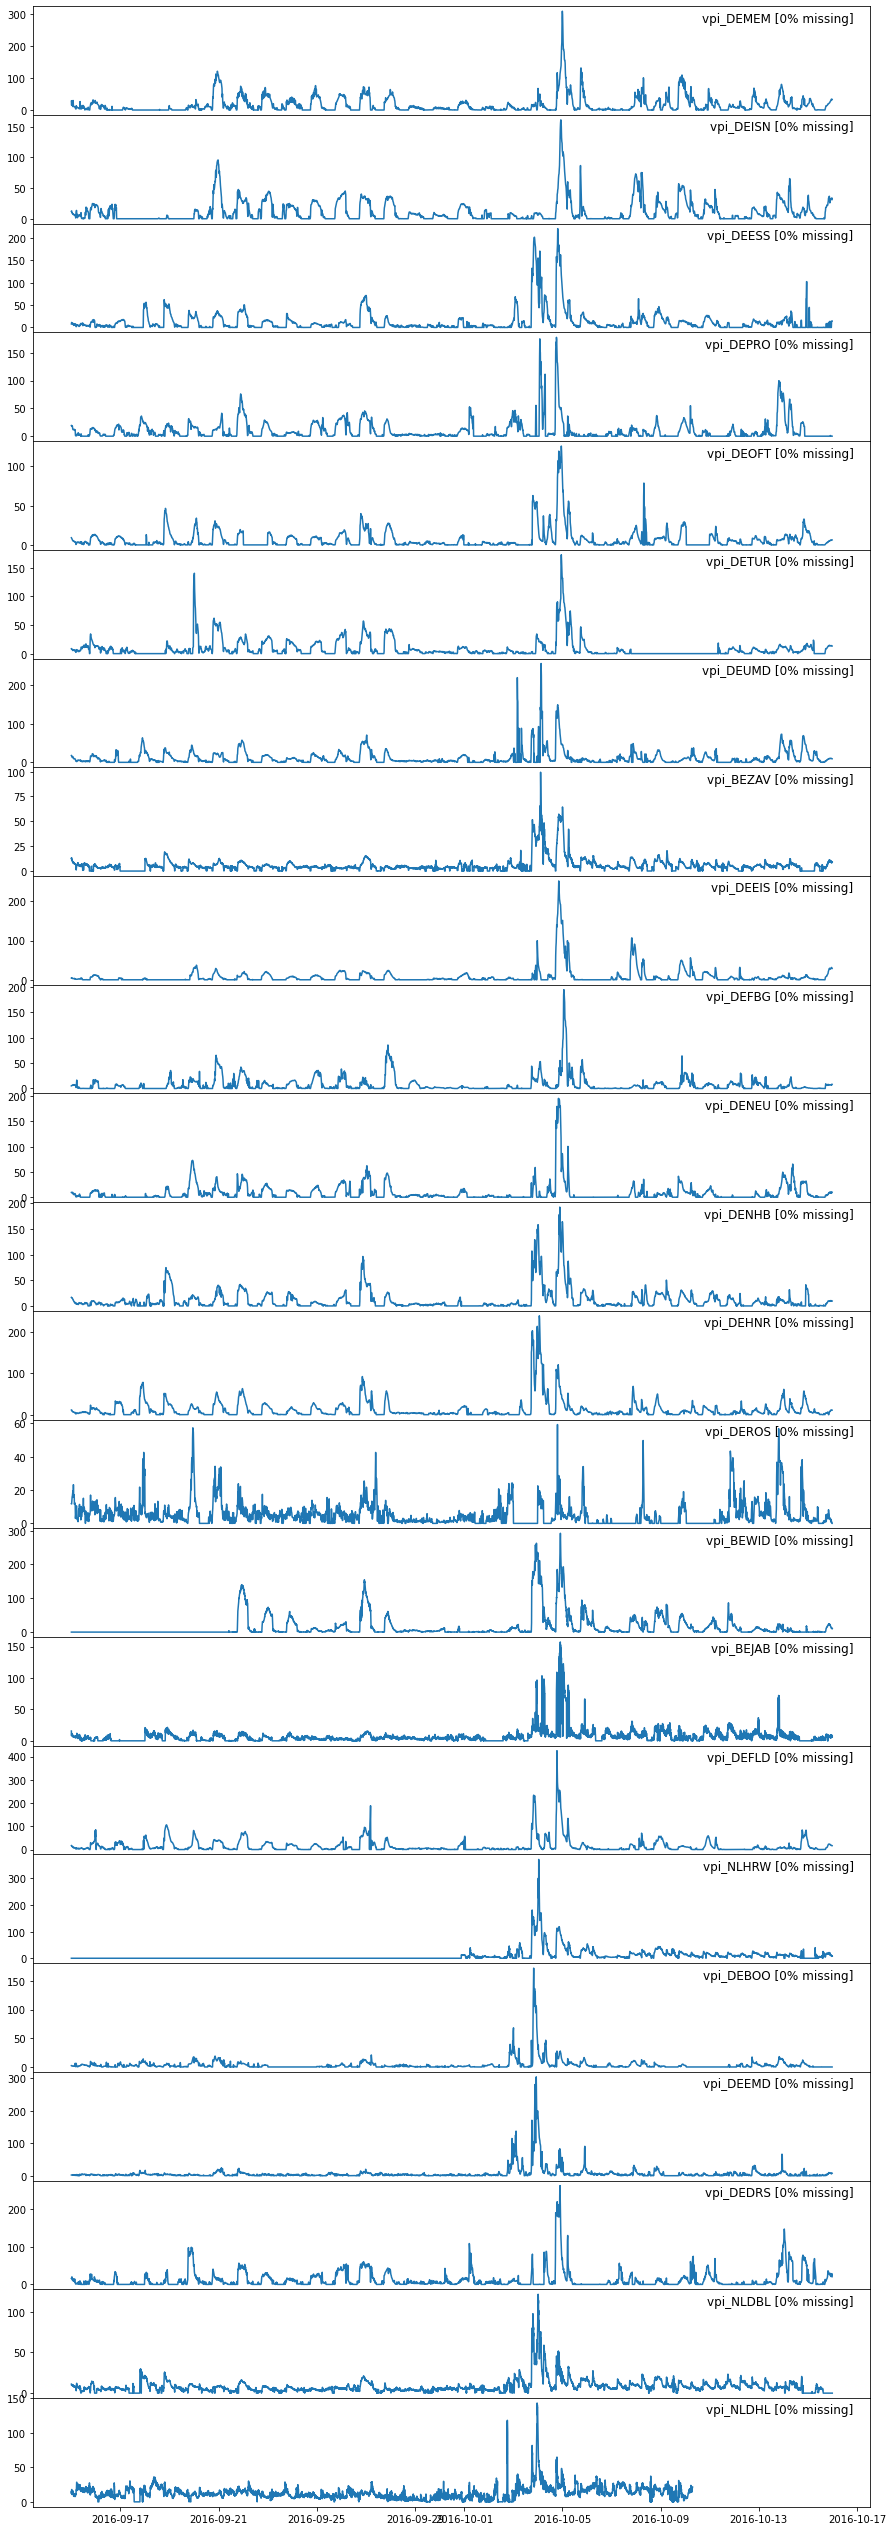

In [4]:
plot_all_vpts(path, 'vid', '2016-09-15', '2016-10-15')

In [54]:
path = '/home/fiona/radar_data/vpi/2016/20160801T0000_to_20161130T2359'
begin = '2016-09-01'
end = '2016-11-01'
var = 'vid'

files = glob.glob(os.path.join(path,'*.nc'))
vid_data, radars = load_data(path, var='vid', begin=begin, end=end)
uv_data, _ = load_data(path, var=['u', 'v'], begin=begin, end=end)
all_data = xr.merge(list(vid_data.values()))
t_range = np.array(all_data.sel(time=slice(begin,end)).time)[::3]

In [56]:
t_range

array(['2016-09-01T00:00:00.000000000', '2016-09-01T00:15:00.000000000',
       '2016-09-01T00:30:00.000000000', ...,
       '2016-11-01T23:15:00.000000000', '2016-11-01T23:30:00.000000000',
       '2016-11-01T23:45:00.000000000'], dtype='datetime64[ns]')

In [59]:
cmax = 200
cmap = cm.get_cmap('YlOrRd')
norm = colors.Normalize(vmin=0.,vmax=cmax)
#norm = colors.LogNorm(vmin=0.,vmax=500)

#watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
#m = Map(layers=(watercolor, ), center=(53, 10), zoom=5)
m = Map(center=(51, 10), zoom=6)
m.layout.height = '600px'

#legend_list = np.linspace(0, cmax, 5)
#legend = LegendControl({c : colors.rgb2hex(cmap(norm(c)))}, name="Legend", position="bottomright")
#m.add_control(legend)


markers = {}
for coord, data in vid_data.items():
    circle = Circle()
    circle.location = coord
    circle.radius = 25*1000 # [in meters]
    circle.stroke = False
    circle.fill_opacity = 1
    
    d = data.sel(time=str(t_range[0]), latitude=coord[0], longitude=coord[1])
    c = colors.rgb2hex(cmap(norm(d)))
    circle.color = 'gray'
    circle.fill_color = c
    markers[coord] = circle
    m.add_layer(circle)
    
    info = Marker(location=coord, draggable=False, title=radars[coord], opacity=0)
    m.add_layer(info)
    
#arrows = {}
#for coord, data in uv_data.items():
#    ...


slider = IntSlider(description='time step:', 
                    value=0,
                    min=0,
                    max= len(t_range)-1,
                    step=1,
                    orientation='horizontal',
                    layout={'width': '500px'}
)
time_info = Text(value=np.datetime_as_string(t_range[slider.value], unit='m'),
                    description='Datetime:'
)
play = Play(max = len(t_range) - 1)
jslink((play, 'value'), (slider, 'value'))

widget_control = WidgetControl(widget=HBox([play, slider, time_info]), position='topright')
m.add_control(widget_control)

def update(change):
    for coord, data in vid_data.items():
        try:
            c = colors.rgb2hex(cmap(norm(data.sel(time=str(t_range[slider.value]), latitude=coord[0], longitude=coord[1]))))
            markers[coord].fill_color = c
            markers[coord].fill_opacity = 1
        except:
            markers[coord].fill_opacity = 0
        
    time_info.value = np.datetime_as_string(t_range[slider.value], unit='m')

slider.observe(update, 'value')

display(m)

Map(center=[51, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [6]:
path = '/home/fiona/radar_data/vpi/2016/20160801T0000_to_20161130T2359'
begin = '2016-09-01'
end = '2016-11-01'
var = ['u', 'v']

files = glob.glob(os.path.join(path,'*.nc'))
radars, names = load_data(path, var=var)

In [53]:
m = Map(center=(51, 10), zoom=5)
m.layout.height = '600px'

for coords, data in radars.items():
    s = 0.1
    u = s * float(data.sel(time=str(t_range[100]), latitude=coords[0], longitude=coords[1]).u)
    v = s * float(data.sel(time=str(t_range[100]), latitude=coords[0], longitude=coords[1]).v)

    norm = np.linalg.norm([2*v, u])*5
    line = Polyline(
        locations=[
            [data.lat-v, data.lon-u],
            [data.lat+v, data.lon+u]
        ],
        color="green" ,
        fill=False,
        line_cap='square',
        weight = int(norm)
    )
    
    s_head = 0.3
    polygon = Polygon(
        locations=[
            [data.lat+v-u*s_head, data.lon+u+2*v*s_head], 
            [data.lat+v+v*s_head, data.lon+u+u*s_head],
            [data.lat+v+u*s_head, data.lon+u-2*v*s_head]
        ],
        color="green",
        fill_color="green",
        fill_opacity = 1,
        weight = 1
    )
    circle = Circle(
        location = coords,
        radius = 25*100, # [in meters]
        stroke = False,
        fill_opacity = 1,
        color = 'gray'
    )
    m.add_layer(line)
    m.add_layer(polygon)
display(m)

Map(center=[51, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [4]:
radars, names = load_data(path, var=['vid'], add_coords=False)

m = Map(center=(51, 10), zoom=6)
m.layout.height = '600px'

for ci, cj in it.combinations(radars, 2):
    di = radars[ci]
    dj = radars[cj]
    corr = di.to_dataframe()['vid'].corr(dj.to_dataframe()['vid'].shift(0))
    if ci != cj and corr > 0.6:
        line = Polyline(
            locations=[
                [di.lat, di.lon],
                [dj.lat, dj.lon]
            ],
            color="red",
            fill=False,
            weight = int(np.round(corr * 10)),
            opacity = 0.2
        )
        m.add_layer(line)

display(m)

Map(center=[51, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [57]:
lags = [-24, -18, -12, -6, 0, 6, 12, 18, 24]
begin = '2016-09-15'
end = '2016-10-15'
radars, names = load_data(path, var=['vid'], begin=begin, end=end, add_coords=False)

def spatio_temp_corr(rcode, radars, names, lags):

    coord_list = list(names.keys())
    names_list = np.array(list(names.values()))

    ci = {v:k for k,v in names.items()}[rcode]
    di = radars[ci]

    sorted_radars = dict(sorted(names.items(), key=lambda x: np.linalg.norm(np.array(ci)-np.array(x[0]))))
    corr = [[radars[ci].to_dataframe()['vid'].corr(radars[cj].to_dataframe()['vid'].shift(lag)) for lag in lags] for cj in sorted_radars.keys()]

    fig, ax = plt.subplots(figsize=(10,5))
    sb.heatmap(pd.DataFrame(corr), cmap='RdBu_r', ax=ax)
    ax.set(title=rcode, xlabel='Lag [minutes]',ylabel='Radars')
    ax.set_yticklabels(list(sorted_radars.values()), rotation=0)
    ax.set_xticklabels(np.array(lags)*5)

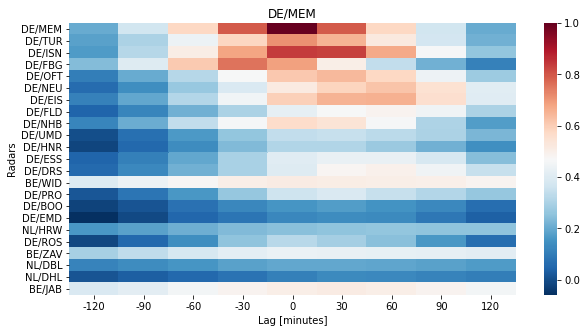

In [59]:
spatio_temp_corr('DE/MEM', radars, names, lags)

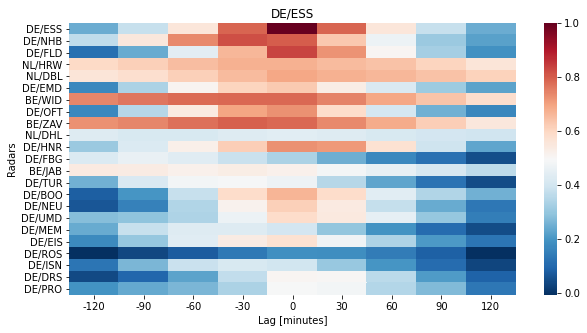

In [60]:
spatio_temp_corr('DE/ESS', radars, names, lags)